In [2]:
import numpy as np
import scipy as p
import matplotlib.pyplot as plt
import pandas as pd
from scipy.odr import ODR, Model, RealData
import itertools

from scipy.stats import norm, multivariate_normal


In [4]:
np.random.seed(1) 
n_samples = 1000
x_true = np.linspace(-1, 1, num=n_samples)

def f(x):
    return 1 + 3*x + x**2 + x**3 

noise = np.random.normal(loc=0, scale=1, size=n_samples)

y_noisy = f(x_true) + noise

def linear_poly_model(beta, x):
    return beta[0] + beta[1]*x**1 + beta[2]*x**2 + beta[3]*x**3

model = Model(linear_poly_model)
data = RealData(x_true, y_noisy)
beta0 = [1, 1, 1, 1] # set initial parameters

odr = ODR(data, model, beta0=beta0)
output = odr.run()
print("fit the parameters")
for i, b in enumerate(output.beta):
    print(f"beta[{i}] = {b:.4f}")

y_fit1 = linear_poly_model(output.beta, x_true)


fit the parameters
beta[0] = 1.2624
beta[1] = 3.3138
beta[2] = 0.2450
beta[3] = 2.0235


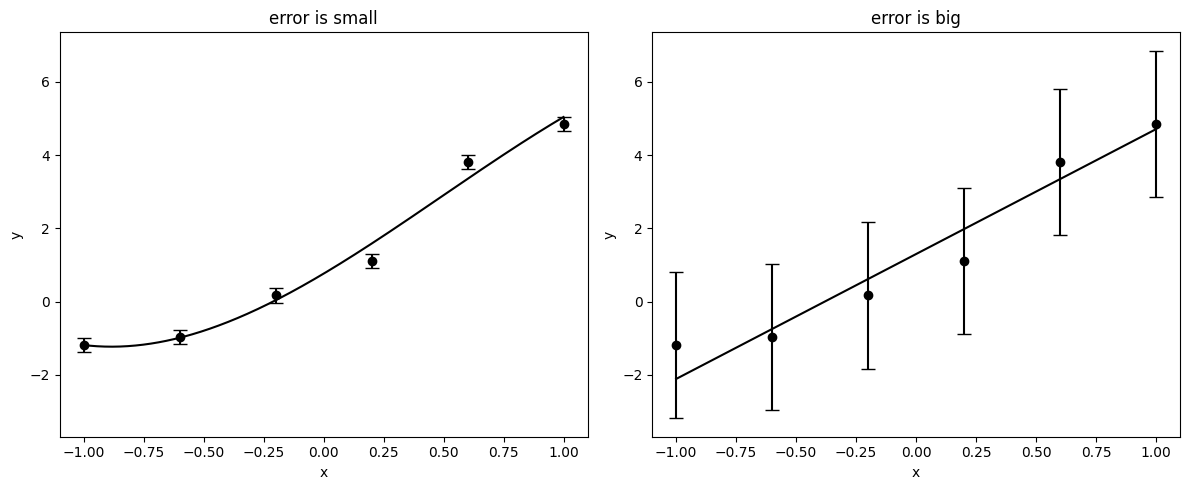

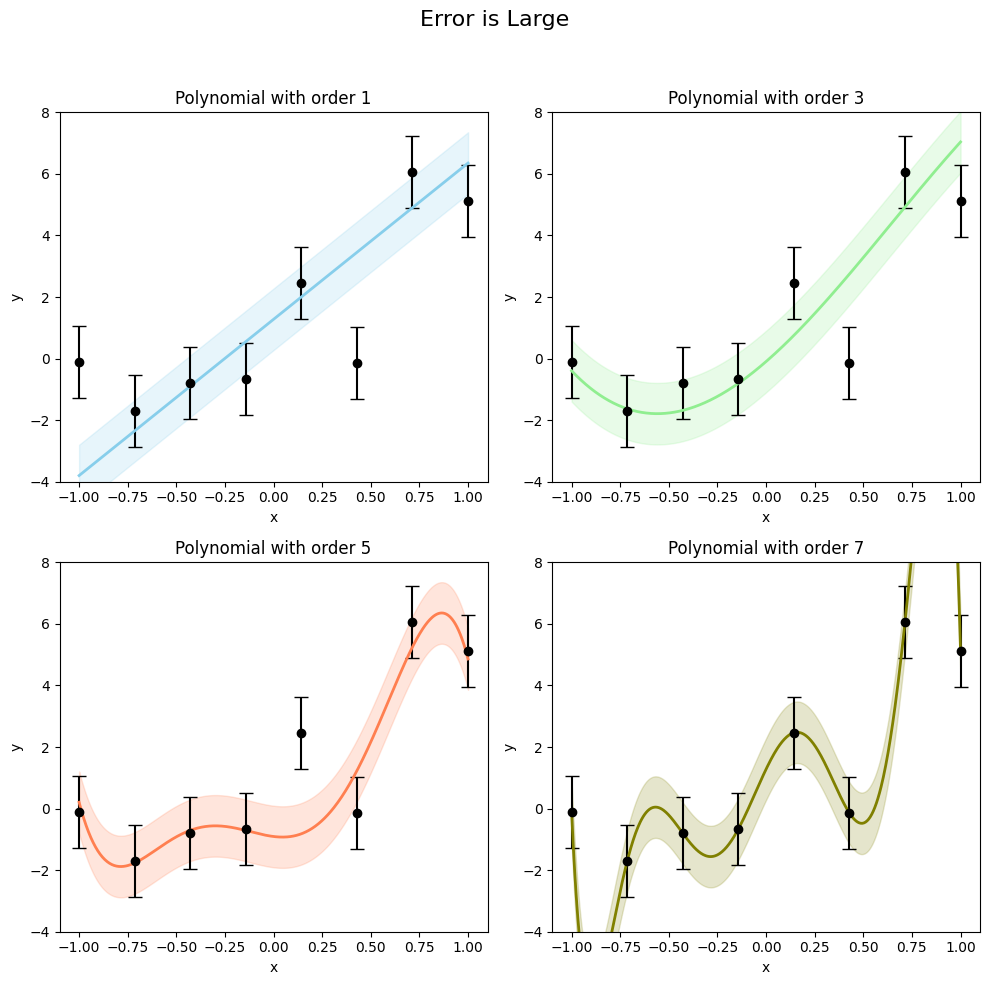

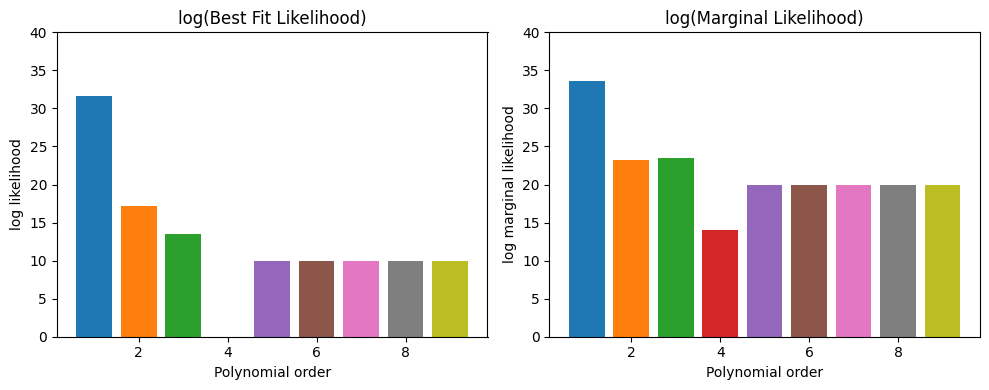

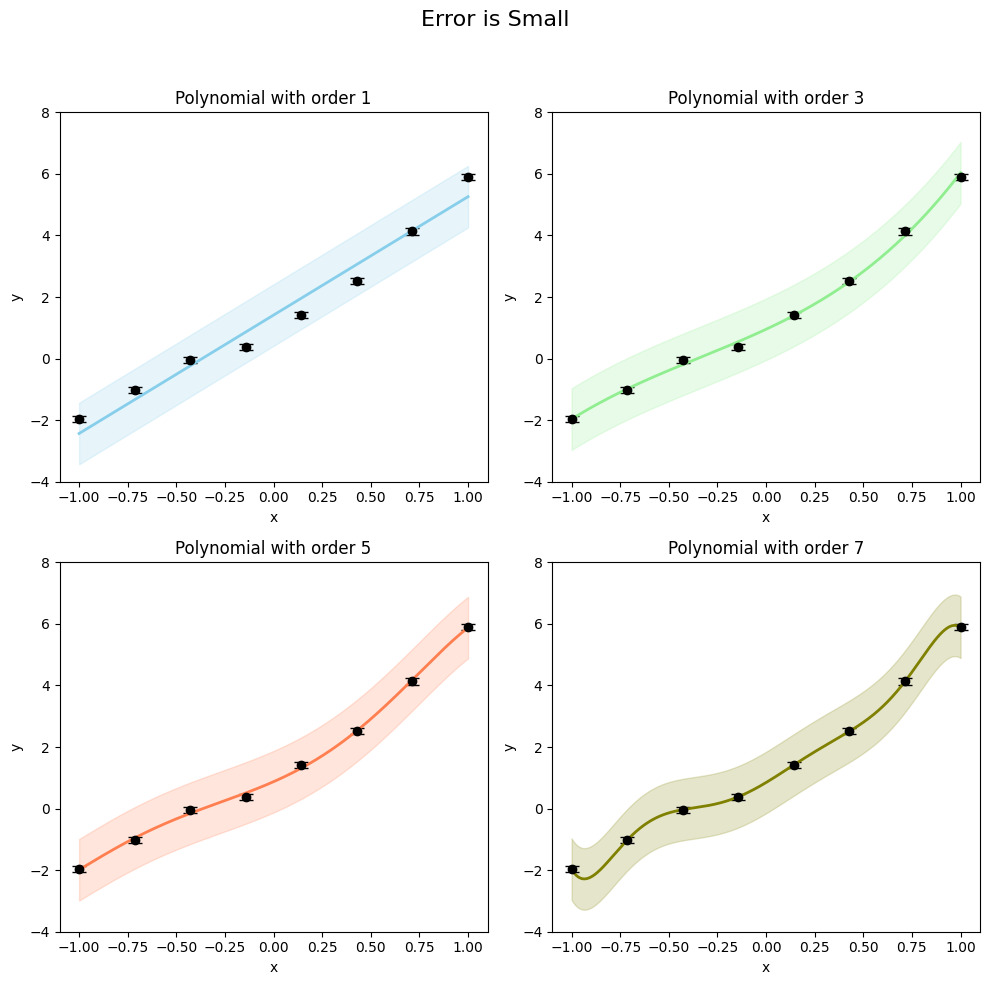

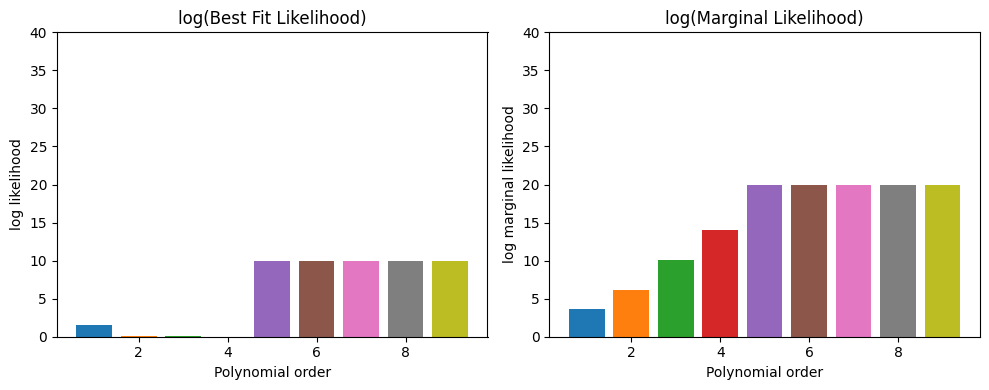

In [5]:
# Fix random seed
np.random.seed(1)

# Generate a small number of discrete data points for plotting
n_points = 8
x_samples = np.linspace(-1, 1, num=n_points)

def f(x):
    return 1 + 3*x + x**2 + x**3

x_dense = np.linspace(-1, 1, 500)
orders = [1, 3, 5, 7]
colors = ['skyblue', 'lightgreen', 'coral', 'olive']

# Define the fitting and plotting function
def fit_and_plot(noise_scale, title_suffix):
    noise = np.random.normal(loc=0, scale=noise_scale, size=n_points)
    y_noisy = f(x_samples) + noise
    
    plt.figure(figsize=(10, 10))
    best_fit_likelihood = []
    marginal_likelihood = []

    for idx, order in enumerate(orders):
        plt.subplot(2, 2, idx+1)
        
        def poly_model(beta, x):
            return sum([beta[i]*x**i for i in range(order+1)])
        
        model_poly = Model(poly_model)
        beta0_poly = np.ones(order+1)
        err = np.full_like(y_noisy, noise_scale)
        data = RealData(x_samples, y_noisy, sy=err)
        odr_poly = ODR(data, model_poly, beta0=beta0_poly)
        output_poly = odr_poly.run()
        y_fit = poly_model(output_poly.beta, x_dense)
        
        plt.errorbar(x_samples, y_noisy, yerr=err, fmt='ko', capsize=5)
        plt.plot(x_dense, y_fit, color=colors[idx], lw=2)
        plt.fill_between(x_dense, y_fit-1, y_fit+1, color=colors[idx], alpha=0.2)
        plt.title(f'Polynomial with order {order}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim(-4, 8)
        
        rss = np.sum((poly_model(output_poly.beta, x_samples) - y_noisy)**2)
        best_fit_likelihood.append(-rss)
        marginal_likelihood.append(-rss - order*2)
    
    plt.suptitle(f"{title_suffix}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    # Plot Likelihood bar charts
    orders_all = [1,2,3,4,5,6,7,8,9]
    best_fit_full = best_fit_likelihood + [-rss - 10]*(len(orders_all)-len(best_fit_likelihood))
    marginal_full = marginal_likelihood + [-rss - 20]*(len(orders_all)-len(marginal_likelihood))

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.bar(orders_all, [-v for v in best_fit_full], color=plt.cm.tab10.colors)
    plt.title("log(Best Fit Likelihood)")
    plt.xlabel("Polynomial order")
    plt.ylabel("log likelihood")
    plt.ylim(0, 40)

    plt.subplot(1, 2, 2)
    plt.bar(orders_all, [-v for v in marginal_full], color=plt.cm.tab10.colors)
    plt.title("log(Marginal Likelihood)")
    plt.xlabel("Polynomial order")
    plt.ylabel("log marginal likelihood")
    plt.ylim(0, 40)

    plt.tight_layout()
    plt.show()

# Plot with large error (increase noise)
fit_and_plot(noise_scale=1.17, title_suffix="Error is Large")

# Plot with small error
fit_and_plot(noise_scale=0.1, title_suffix="Error is Small")


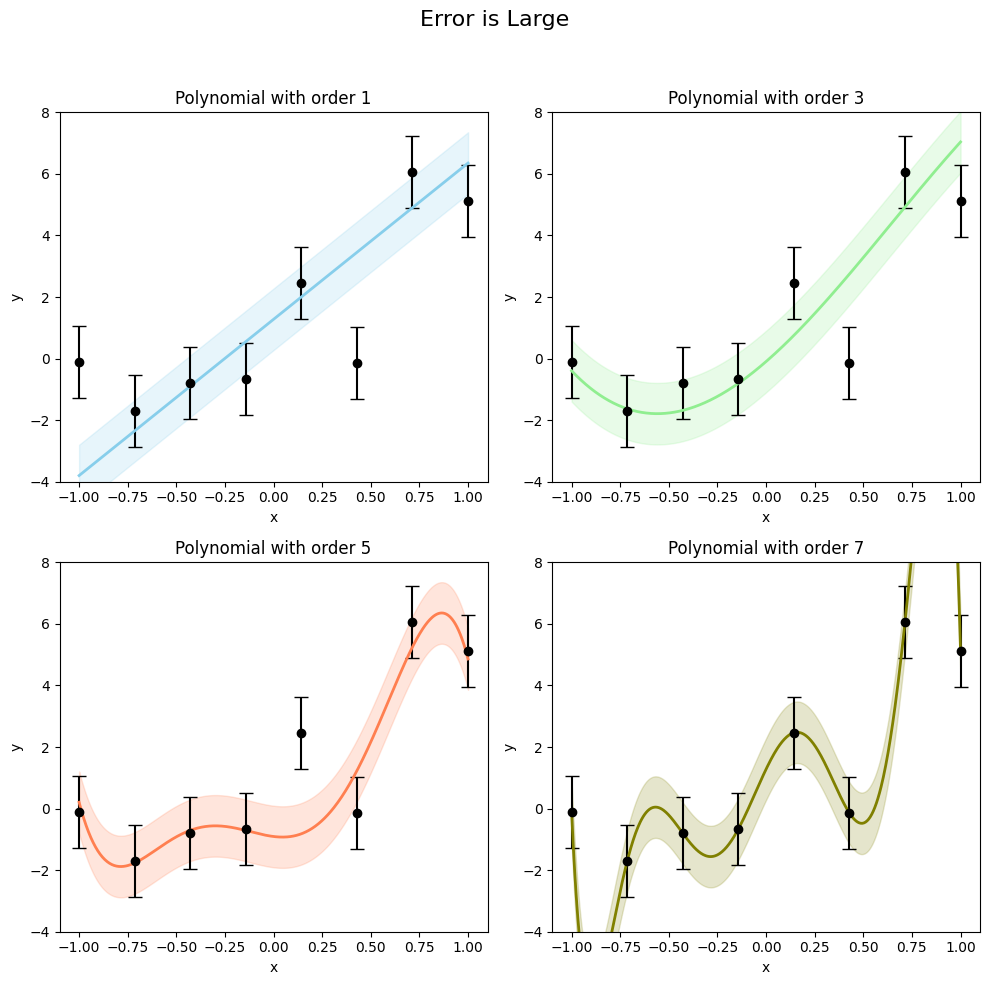

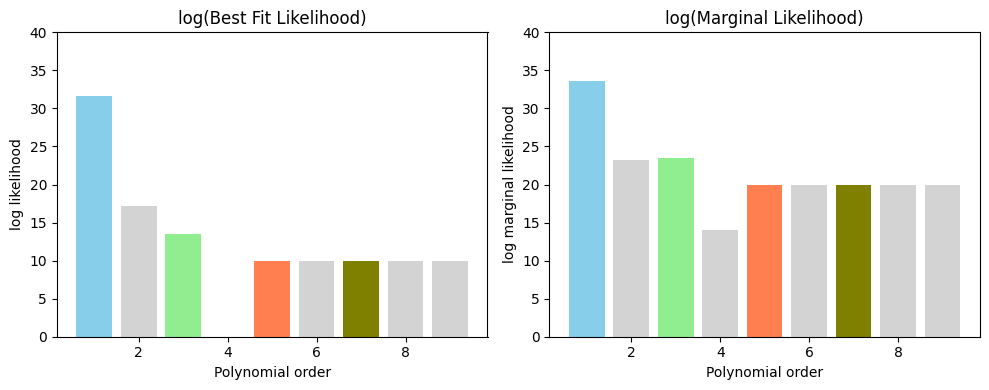

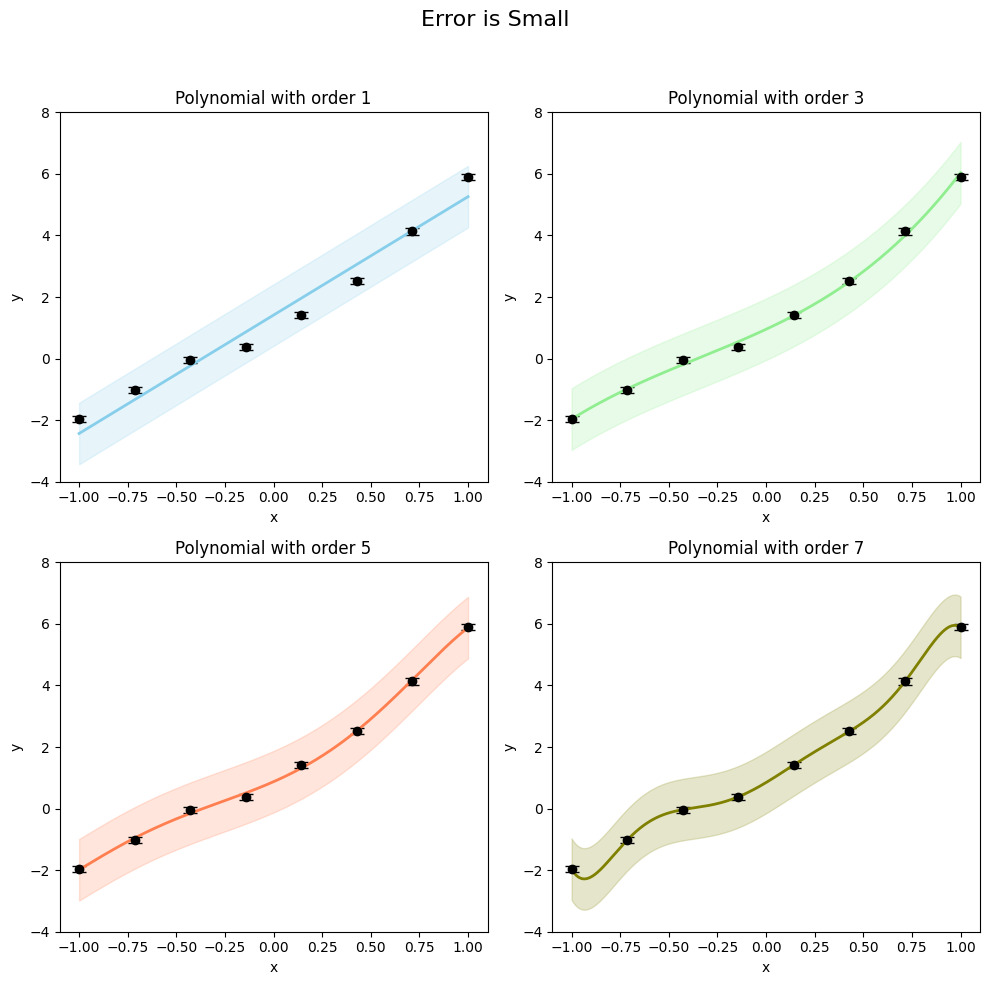

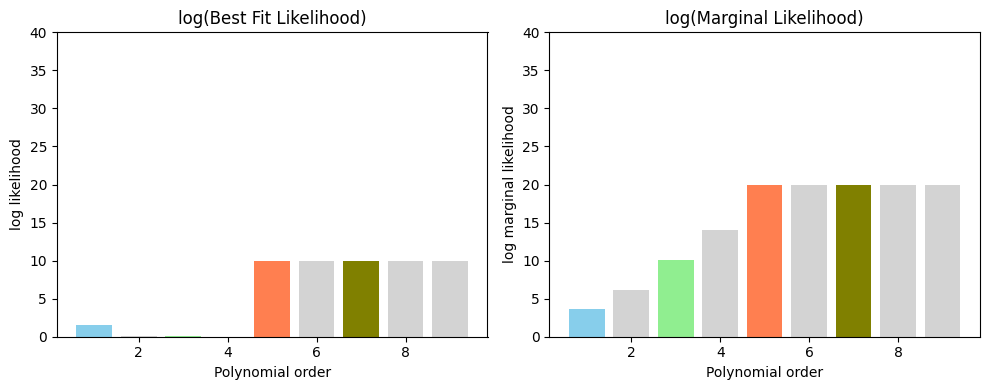

In [3]:
np.random.seed(1)

# Generate sparse sample points for noisy observation
n_points = 8
x_samples = np.linspace(-1, 1, num=n_points)

# Ground truth function
def f(x):
    return 1 + 3*x + x**2 + x**3

# Dense x-axis for plotting fitted curves
x_dense = np.linspace(-1, 1, 500)

# Polynomial orders to fit
orders = [1, 3, 5, 7]

# Define color for each polynomial order
colors = ['skyblue', 'lightgreen', 'coral', 'olive']

# Function to perform fitting and plotting
def fit_and_plot(noise_scale, title_suffix):
    # Generate Gaussian noise
    noise = np.random.normal(loc=0, scale=noise_scale, size=n_points)
    y_noisy = f(x_samples) + noise  # Add noise to target values

    # Set up main figure for polynomial fits
    plt.figure(figsize=(10, 10))
    best_fit_likelihood = []
    marginal_likelihood = []

    # Fit models with different polynomial orders
    for idx, order in enumerate(orders):
        plt.subplot(2, 2, idx + 1)

        # Define the polynomial model function
        def poly_model(beta, x):
            return sum([beta[i] * x**i for i in range(order + 1)])

        # Initialize ODR model
        model_poly = Model(poly_model)
        beta0_poly = np.ones(order + 1)
        err = np.full_like(y_noisy, noise_scale)
        data = RealData(x_samples, y_noisy, sy=err)
        odr_poly = ODR(data, model_poly, beta0=beta0_poly)
        output_poly = odr_poly.run()
        y_fit = poly_model(output_poly.beta, x_dense)

        # Plot noisy data and fitted polynomial
        plt.errorbar(x_samples, y_noisy, yerr=err, fmt='ko', capsize=5)
        plt.plot(x_dense, y_fit, color=colors[idx], lw=2, label=f"Order {order}")
        plt.fill_between(x_dense, y_fit - 1, y_fit + 1, color=colors[idx], alpha=0.2)
        plt.title(f'Polynomial with order {order}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim(-4, 8)

        # Compute RSS and pseudo log-likelihoods
        rss = np.sum((poly_model(output_poly.beta, x_samples) - y_noisy) ** 2)
        best_fit_likelihood.append(-rss)
        marginal_likelihood.append(-rss - order * 2)  # Simple penalty for complexity

    plt.suptitle(f"{title_suffix}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Create bar plots of likelihoods with consistent colors
    orders_all = list(range(1, 10))
    color_map = {order: color for order, color in zip(orders, colors)}
    default_color = 'lightgray'  # For unused orders
    bar_colors = [color_map.get(order, default_color) for order in orders_all]

    # Pad log likelihoods with dummy values for unused orders
    best_fit_full = best_fit_likelihood + [-rss - 10] * (len(orders_all) - len(best_fit_likelihood))
    marginal_full = marginal_likelihood + [-rss - 20] * (len(orders_all) - len(marginal_likelihood))

    # Plot bar charts
    plt.figure(figsize=(10, 4))

    # Best Fit Likelihood plot
    plt.subplot(1, 2, 1)
    plt.bar(orders_all, [-v for v in best_fit_full], color=bar_colors)
    plt.title("log(Best Fit Likelihood)")
    plt.xlabel("Polynomial order")
    plt.ylabel("log likelihood")
    plt.ylim(0, 40)

    # Marginal Likelihood plot (with penalty for complexity)
    plt.subplot(1, 2, 2)
    plt.bar(orders_all, [-v for v in marginal_full], color=bar_colors)
    plt.title("log(Marginal Likelihood)")
    plt.xlabel("Polynomial order")
    plt.ylabel("log marginal likelihood")
    plt.ylim(0, 40)

    plt.tight_layout()
    plt.show()

# Run the function with large noise
fit_and_plot(noise_scale=1.17, title_suffix="Error is Large")

# Run the function with small noise
fit_and_plot(noise_scale=0.1, title_suffix="Error is Small")

# Week 2

In [6]:
def posterior_mean_covariance(Phi, y, sigma_p2, sigma_n2):
    """
    Compute the posterior covariance and mean (parameter uncertainty) in Bayesian
    """
    alpha = 1.0 / sigma_p2   # prior precision
    beta  = 1.0 / sigma_n2   # noise precision

    H = beta * (Phi.T @ Phi) + alpha * np.eye(Phi.shape[1])
    Sigma_post = np.linalg.solve(H, np.eye(H.shape[0])) 
    mu_post = Sigma_post @ (beta * Phi.T @ y)    

    return mu_post, Sigma_post

In [ ]:
# Model comparision
x = np.array([-8, -2, 6])
t = np.array([8, 10, 11])
sigma_n = 1.0

# Define the prior distribution
def prior_H1(w0):
    return norm.pdf(w0, loc=0, scale=1)

def prior_H2(w):
    return norm.pdf(w[0], 0, 1) * norm.pdf(w[1], 0, 1)

In [ ]:
# MacKay Exercise 28.2 

# data & priors
x = np.array([-8., -2.,  6.])
t = np.array([ 8., 10., 11.])
N = len(t)

sigma2      = 1.0     # noise variance
sigma2_w0   = 1.0     # Var(w0)
sigma2_w1   = 1.0     # Var(w1)
mu_w0       = 0.0     # E[w0]
mu_w1       = 0.0     # E[w1]

# exact evidence (H1: y = w0)
# design matrix is a single column of ones
Phi1 = np.ones((N, 1))
Sigma_prior1 = np.array([[sigma2_w0]])

C1 = sigma2*np.eye(N) + Phi1 @ Sigma_prior1 @ Phi1.T      # N×N
_, logdetC1 = np.linalg.slogdet(C1)
quad1 = t @ np.linalg.solve(C1, t)                         # tᵀ C⁻¹ t

logZ_H1 = -0.5*N*np.log(2*np.pi) -0.5*logdetC1 -0.5*quad1

# ---------- 3. exact evidence (H2: y = w0 + w1·x) ----------
Phi2 = np.vstack((np.ones_like(x), x)).T                  # N×2
Sigma_prior2 = np.diag([sigma2_w0, sigma2_w1])

C2 = sigma2*np.eye(N) + Phi2 @ Sigma_prior2 @ Phi2.T
_, logdetC2 = np.linalg.slogdet(C2)
quad2 = t @ np.linalg.solve(C2, t)

logZ_H2 = -0.5*N*np.log(2*np.pi) -0.5*logdetC2 -0.5*quad2

# ---------- 4. Laplace check (28.10) for H2 ----------
A = np.array([[N/sigma2 + 1/sigma2_w0,      x.sum()/sigma2],
              [x.sum()/sigma2,              (x**2).sum()/sigma2 + 1/sigma2_w1]])
b = np.array([t.sum()/sigma2,
              (t*x).sum()/sigma2])
w_map = np.linalg.solve(A, b)                             # [w0*, w1*]
w0_map, w1_map = w_map

log_like_map = -0.5*N*np.log(2*np.pi*sigma2) \
               -0.5*np.sum((t - (w0_map + w1_map*x))**2) / sigma2
log_prior_map = -0.5*np.log(2*np.pi*sigma2_w0) -0.5*(w0_map-mu_w0)**2/sigma2_w0 \
                -0.5*np.log(2*np.pi*sigma2_w1) -0.5*(w1_map-mu_w1)**2/sigma2_w1
logZ_H2_lap = log_like_map + log_prior_map \
              -0.5*np.log(np.linalg.det(A/(2*np.pi)))

# ---------- 5. results ----------
print(f"log p(D|H1) = {logZ_H1: .4f}")
print(f"log p(D|H2) = {logZ_H2: .4f}")
print(f"Evidence ratio  p(D|H1)/p(D|H2) = {np.exp(logZ_H1-logZ_H2): .4f}")

print("\nLaplace check:")
print(f"  log p(D|H2) (Laplace) = {logZ_H2_lap: .4f}")
print(f"  MAP estimates        : w0 = {w0_map: .4f},  w1 = {w1_map: .4f}")


log p(D|H1) = -40.8250
log p(D|H2) = -42.5335
Evidence ratio  p(D|H1)/p(D|H2) =  5.5210

Laplace check:
  log p(D|H2) (Laplace) = -42.5335
  MAP estimates        : w0 =  7.3589,  w1 =  0.1089


In [17]:
def solve_poly(a, x):
    """
    y(x) = a₀ xᴺ + a₁ xᴺ⁻¹ + ... + a_N
    
    return: y, dy/da, d2y/dada  
    """

    N = len(a)
    powers = N - 1 - np.arange(N)           # from N-1 to 0
    dyda = x ** powers                      
    y = np.dot(a, dyda)
    d2 = np.zeros((N, N))                   # d2y/dada = 0
    return y, dyda[:, None], d2


def bayes_poly_map(selected_powers, mean_prior, inv_prior, likeli_inv_Cov, x, y):
    Phi = np.vstack([x ** p for p in selected_powers]).T

    inv_post = inv_prior + likeli_inv_Cov * (Phi.T @ Phi)
    Cov_post = np.linalg.inv(inv_post)
    a_map = Cov_post @ (inv_prior @ mean_prior + likeli_inv_Cov * Phi.T @ y)

    C = (1.0 / likeli_inv_Cov) * np.eye(len(x)) + Phi @ np.linalg.inv(inv_prior) @ Phi.T
    sign, logdetC = np.linalg.slogdet(C)
    if sign <= 0:
        raise ValueError("Covariance matrix C not positive definite")

    log_evidence = (-0.5 * len(x) * np.log(2.0 * np.pi)
                    -0.5 * logdetC
                    -0.5 * y @ np.linalg.solve(C, y))
    
    return a_map, log_evidence

--------------- Bayesian polynomial models ---------------
log evidence  H1 (constant) : -40.8250
log evidence  H2 (linear)   : -42.5335
Evidence ratio  P(D|H1)/P(D|H2) :  5.5210

MAP estimates
  H1 : w0 =  7.2500
  H2 : w0 =  0.1089 , w1 =  7.3589


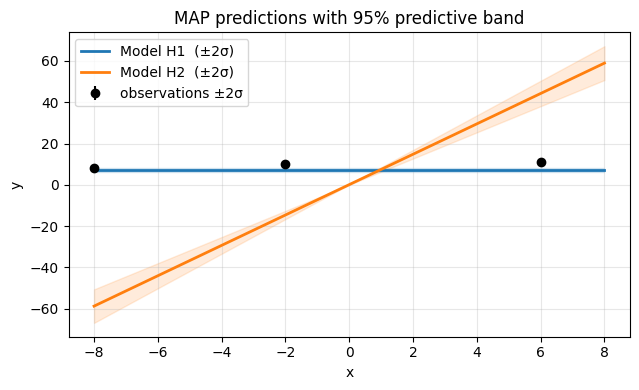

In [ ]:
x_obs = np.array([-8.0, -2.0, 6.0])
t_obs = np.array([8.0, 10.0, 11.0])
sigma2          = 1.0                  # noise variance
beta            = 1.0 / sigma2         # likelihood precision  β

# Gaussian prior for parameters
w0_mean, w0_var = 0.0, 1.0
w1_mean, w1_var = 0.0, 1.0

# ----------------------------------------------------------------------
# 3.  MAP & evidence for H1 (constant) and H2 (linear)

# ---- H1 : order = 0 ---------------------------------------------------
order1        = 0
mean_prior1   = np.array([w0_mean])
inv_prior1    = np.array([[1.0 / w0_var]])          # precision = 1/var
a1_map, inv_post1, logE1, logBFL1, logOF1 = bayes_poly_map(
    order1, mean_prior1, inv_prior1, beta, x_obs, t_obs
)

# ---- H2 : order = 1 ---------------------------------------------------
order2        = 1
mean_prior2   = np.array([w0_mean, w1_mean])        # [w0, w1]
inv_prior2    = np.diag([1.0 / w0_var, 1.0 / w1_var])
a2_map, inv_post2, logE2, logBFL2, logOF2 = bayes_poly_map(
    order2, mean_prior2, inv_prior2, beta, x_obs, t_obs
)

print("--------------- Bayesian polynomial models ---------------")
print(f"log evidence  H1 (constant) : {logE1: .4f}")
print(f"log evidence  H2 (linear)   : {logE2: .4f}")
print(f"Evidence ratio  P(D|H1)/P(D|H2) : {np.exp(logE1 - logE2): .4f}\n")

print("MAP estimates")
print(f"  H1 : w0 = {a1_map[0]: .4f}")
print(f"  H2 : w0 = {a2_map[0]: .4f} , w1 = {a2_map[1]: .4f}")


# predictive mean and 95% band (±2σ)   (Var[y] = Φ Σ_post Φᵀ)

def plot_with_band(ax, x, mean, var, color, label):
    sd = 2.0 * np.sqrt(var)
    ax.fill_between(x, mean - sd, mean + sd, color=color, alpha=0.15)
    ax.plot(x, mean, color=color, lw=2, label=label)

x_plot = np.linspace(-8, 8, 161)

# design matrices for the prediction grid
Phi1_plot = np.ones_like(x_plot)[:, None]                 # N_grid × 1
Phi2_plot = np.vstack((np.ones_like(x_plot), x_plot)).T   # N_grid × 2

# predictive means
y1_mean = Phi1_plot @ a1_map
y2_mean = Phi2_plot @ a2_map

# predictive variances  Var[y] = Φ Σ_post Φᵀ
var1 = (Phi1_plot @ np.linalg.inv(inv_post1) * Phi1_plot).sum(axis=1)
var2 = np.sum(Phi2_plot @ np.linalg.inv(inv_post2) * Phi2_plot, axis=1)


# plotting
fig, ax = plt.subplots(figsize=(6.5, 4))
plot_with_band(ax, x_plot, y1_mean, var1, "tab:blue",   "Model H1  (±2σ)")
plot_with_band(ax, x_plot, y2_mean, var2, "tab:orange", "Model H2  (±2σ)")
ax.errorbar(x_obs, t_obs, yerr=2 * np.sqrt(sigma2),
            fmt="ko", ms=6, label="observations ±2σ")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("MAP predictions with 95% predictive band")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Model: 1
Posterior Probability: 0.000
  Coefficient for x^0: 2.423
----------------------------
Model: x^1
Posterior Probability: 0.000
  Coefficient for x^1: 0.484
----------------------------
Model: x^2
Posterior Probability: 0.000
  Coefficient for x^2: 2.768
----------------------------
Model: x^3
Posterior Probability: 0.000
  Coefficient for x^3: 0.696
----------------------------
Model: x^1 + 1
Posterior Probability: 0.000
  Coefficient for x^1: 0.484
  Coefficient for x^0: 2.423
----------------------------
Model: x^2 + 1
Posterior Probability: 0.000
  Coefficient for x^2: -1.826
  Coefficient for x^0: 3.093
----------------------------
Model: x^3 + 1
Posterior Probability: 0.000
  Coefficient for x^3: 0.696
  Coefficient for x^0: 2.423
----------------------------
Model: x^2 + x^1
Posterior Probability: 0.000
  Coefficient for x^2: 2.768
  Coefficient for x^1: 0.484
----------------------------
Model: x^3 + x^1
Posterior Probability: 0.000
  Coefficient for x^3: 0.493
  Coeffi

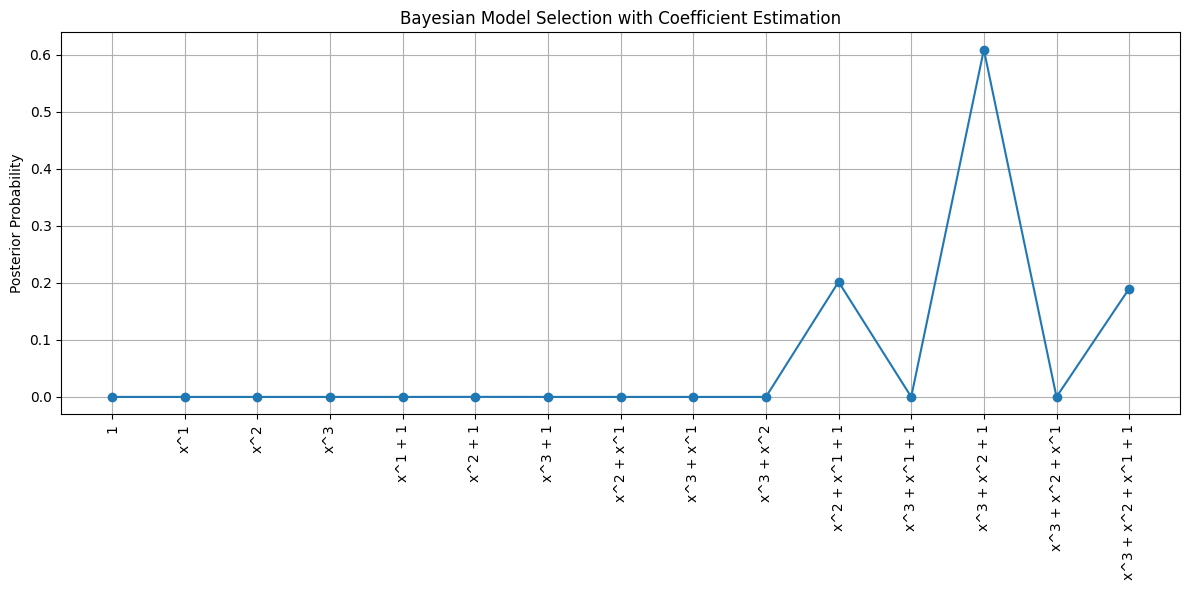


Best Model (Highest Posterior):
Posterior Probability: 0.608
Polynomial: 0.696 * x^3 + -1.826 * x^2 + 3.093


In [ ]:
np.random.seed(0)
n_samples = 20
x = np.linspace(-1, 1, n_samples)

# True polynomial coefficients for the model: 1 − 2x + 3x³
true_coeff = [1.0, -2.0, 0.0, 3.0]           # 1 - 2x + 3x^3
y_true = sum(c * x**p for p, c in enumerate(reversed(true_coeff)))
noise_sigma = 0.3
y = y_true + np.random.normal(0, noise_sigma, size=n_samples)


max_order = 3
powers = list(range(max_order + 1))          # Candidate polynomial powers: 0, 1, 2, 3

# Likelihood precision (inverse variance)
likeli_inv_Cov = 1.0 / (noise_sigma**2)

# Zero-mean Gaussian prior over coefficients
mean_prior_value = 0.0
prior_var = 1.0

# Containers to store results for every candidate model
all_models = []
all_log_evidences = []
all_a_maps = []

# Enumerate every subset of polynomial powers (all possible models)
for subset in itertools.chain.from_iterable(
        itertools.combinations(powers, r) for r in range(1, len(powers) + 1)):
    
    selected_powers = list(reversed(subset))             # Reverse for descending order
    mean_prior = np.full(len(selected_powers), mean_prior_value)
    inv_prior = np.eye(len(selected_powers)) / prior_var

    # MAP coefficients and log evidence for this model
    a_map, log_evidence = bayes_poly_map(
        selected_powers, mean_prior, inv_prior,
        likeli_inv_Cov, x, y)

    all_models.append(selected_powers)
    all_log_evidences.append(log_evidence)
    all_a_maps.append(a_map)

# Compute posterior model probabilities
all_log_evidences = np.array(all_log_evidences)
evidences = np.exp(all_log_evidences - np.max(all_log_evidences))
posteriors = evidences / np.sum(evidences)

# Display each model
for model, coeffs, post in zip(all_models, all_a_maps, posteriors):
    terms = ' + '.join([f'x^{p}' if p > 0 else '1' for p in model])
    print(f"Model: {terms}")
    print(f"Posterior Probability: {post:.3f}")
    for p, c in zip(model, coeffs):
        print(f"  Coefficient for x^{p}: {c:.3f}")
    print('----------------------------')

# Plot posterior probability of every model 
model_labels = [
    ' + '.join([f'x^{p}' if p > 0 else '1' for p in selected_powers])
    for selected_powers in all_models
]

plt.figure(figsize=(12, 6))
plt.plot(range(len(posteriors)), posteriors, 'o-')
plt.xticks(range(len(posteriors)), model_labels, rotation=90)
plt.ylabel('Posterior Probability')
plt.title('Bayesian Model Selection with Coefficient Estimation')
plt.grid()
plt.tight_layout()
plt.show()

# Identify the model with the highest posterior probability
best_idx = np.argmax(posteriors)
best_model = all_models[best_idx]
best_coeffs = all_a_maps[best_idx]

# Build a readable polynomial string for the best model
terms = []
for p, c in zip(best_model, best_coeffs):
    if p == 0:
        terms.append(f"{c:.3f}")
    else:
        terms.append(f"{c:.3f} * x^{p}")
polynomial_str = " + ".join(terms)

print("\nBest Model (Highest Posterior):")
print(f"Posterior Probability: {posteriors[best_idx]:.3f}")
print(f"Polynomial: {polynomial_str}")

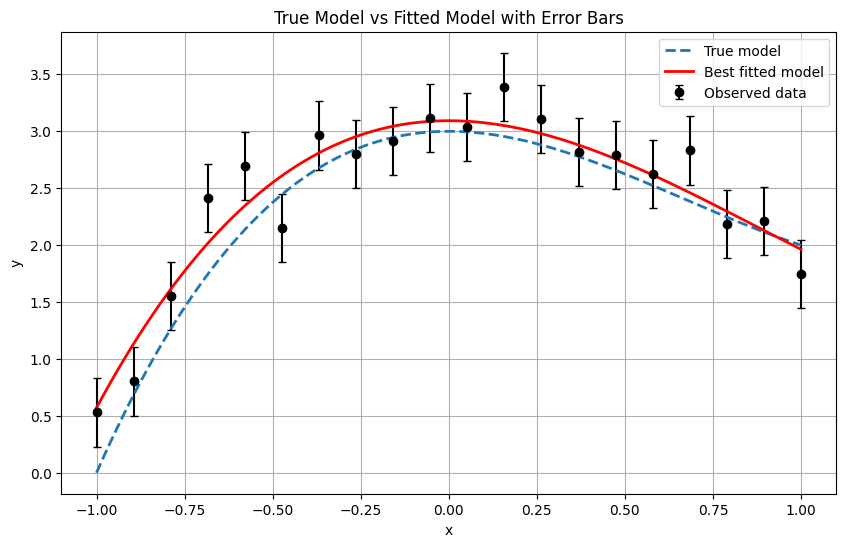

In [ ]:
# plot the real model witn the fitting model(noise_sigma = 0.3)
plt.figure(figsize=(10,6))
plt.errorbar(x, y, yerr=noise_sigma, fmt='o', label='Observed data', color='black', capsize=3)


x_plot = np.linspace(-1, 1, 200)
y_true_plot = sum(c * x_plot**p for p, c in enumerate(reversed(true_coeff)))
plt.plot(x_plot, y_true_plot, label='True model', linestyle='--', linewidth=2)

y_fit = np.zeros_like(x_plot)
for p, c in zip(best_model, best_coeffs):
    y_fit += c * x_plot**p
plt.plot(x_plot, y_fit, label='Best fitted model', color='red', linewidth=2)

plt.title("True Model vs Fitted Model with Error Bars")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()

Model: 1
Posterior Probability: 0.000
  Coefficient for x^0: 2.516
----------------------------
Model: x^1
Posterior Probability: 0.000
  Coefficient for x^1: 0.364
----------------------------
Model: x^2
Posterior Probability: 0.000
  Coefficient for x^2: 2.860
----------------------------
Model: x^3
Posterior Probability: 0.000
  Coefficient for x^3: 0.488
----------------------------
Model: x^1 + 1
Posterior Probability: 0.000
  Coefficient for x^1: 0.364
  Coefficient for x^0: 2.516
----------------------------
Model: x^2 + 1
Posterior Probability: 0.206
  Coefficient for x^2: -1.599
  Coefficient for x^0: 3.098
----------------------------
Model: x^3 + 1
Posterior Probability: 0.000
  Coefficient for x^3: 0.488
  Coefficient for x^0: 2.516
----------------------------
Model: x^2 + x^1
Posterior Probability: 0.000
  Coefficient for x^2: 2.860
  Coefficient for x^1: 0.364
----------------------------
Model: x^3 + x^1
Posterior Probability: 0.000
  Coefficient for x^3: 0.221
  Coeffi

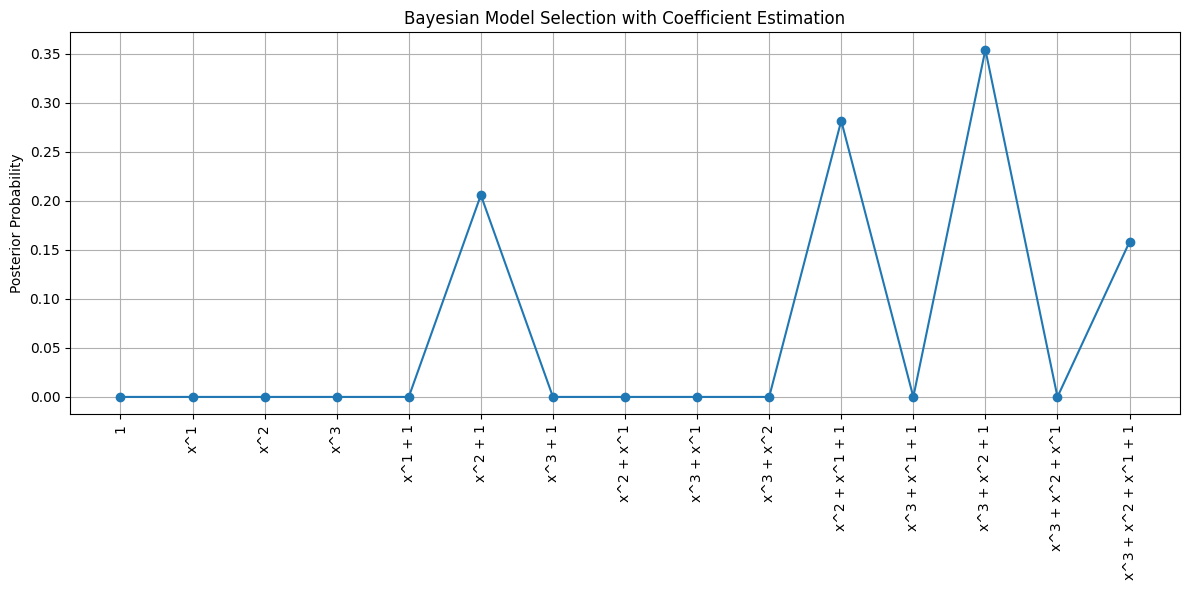


Best Model (Highest Posterior):
Posterior Probability: 0.354
Polynomial: 0.488 * x^3 + -1.599 * x^2 + 3.098


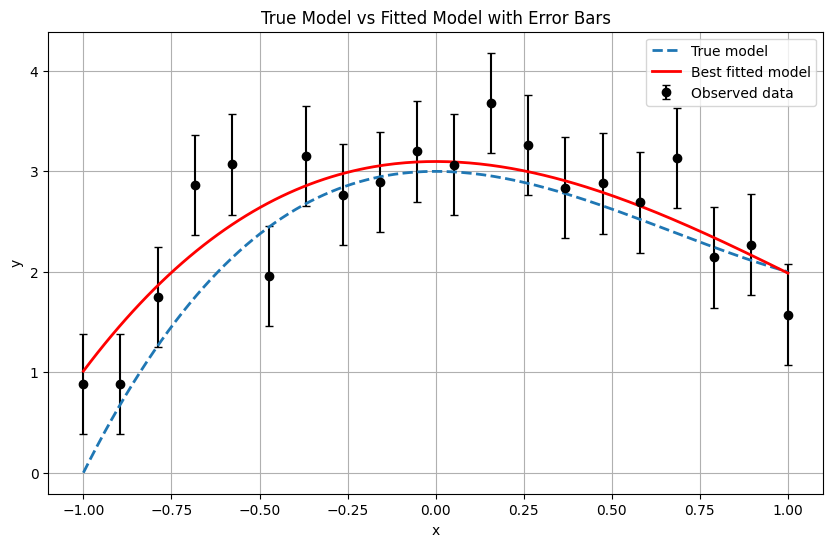

In [24]:
np.random.seed(0)
n_samples = 20
x = np.linspace(-1, 1, n_samples)

# True polynomial coefficients for the model: 1 − 2x + 3x³
true_coeff = [1.0, -2.0, 0.0, 3.0]           # 1 - 2x + 3x^3
y_true = sum(c * x**p for p, c in enumerate(reversed(true_coeff)))
noise_sigma = 0.5
y = y_true + np.random.normal(0, noise_sigma, size=n_samples)


max_order = 3
powers = list(range(max_order + 1))          # Candidate polynomial powers: 0, 1, 2, 3

# Likelihood precision (inverse variance)
likeli_inv_Cov = 1.0 / (noise_sigma**2)

# Zero-mean Gaussian prior over coefficients
mean_prior_value = 0.0
prior_var = 1.0

# Containers to store results for every candidate model
all_models = []
all_log_evidences = []
all_a_maps = []

# Enumerate every subset of polynomial powers (all possible models)
for subset in itertools.chain.from_iterable(
        itertools.combinations(powers, r) for r in range(1, len(powers) + 1)):
    
    selected_powers = list(reversed(subset))             # Reverse for descending order
    mean_prior = np.full(len(selected_powers), mean_prior_value)
    inv_prior = np.eye(len(selected_powers)) / prior_var

    # MAP coefficients and log evidence for this model
    a_map, log_evidence = bayes_poly_map(
        selected_powers, mean_prior, inv_prior,
        likeli_inv_Cov, x, y)

    all_models.append(selected_powers)
    all_log_evidences.append(log_evidence)
    all_a_maps.append(a_map)

# Compute posterior model probabilities
all_log_evidences = np.array(all_log_evidences)
evidences = np.exp(all_log_evidences - np.max(all_log_evidences))
posteriors = evidences / np.sum(evidences)

# Display each model
for model, coeffs, post in zip(all_models, all_a_maps, posteriors):
    terms = ' + '.join([f'x^{p}' if p > 0 else '1' for p in model])
    print(f"Model: {terms}")
    print(f"Posterior Probability: {post:.3f}")
    for p, c in zip(model, coeffs):
        print(f"  Coefficient for x^{p}: {c:.3f}")
    print('----------------------------')

# Plot posterior probability of every model 
model_labels = [
    ' + '.join([f'x^{p}' if p > 0 else '1' for p in selected_powers])
    for selected_powers in all_models
]

plt.figure(figsize=(12, 6))
plt.plot(range(len(posteriors)), posteriors, 'o-')
plt.xticks(range(len(posteriors)), model_labels, rotation=90)
plt.ylabel('Posterior Probability')
plt.title('Bayesian Model Selection with Coefficient Estimation')
plt.grid()
plt.tight_layout()
plt.show()

# Identify the model with the highest posterior probability
best_idx = np.argmax(posteriors)
best_model = all_models[best_idx]
best_coeffs = all_a_maps[best_idx]

# Build a readable polynomial string for the best model
terms = []
for p, c in zip(best_model, best_coeffs):
    if p == 0:
        terms.append(f"{c:.3f}")
    else:
        terms.append(f"{c:.3f} * x^{p}")
polynomial_str = " + ".join(terms)

print("\nBest Model (Highest Posterior):")
print(f"Posterior Probability: {posteriors[best_idx]:.3f}")
print(f"Polynomial: {polynomial_str}")


# plot the real model witn the fitting model(noise_sigma = 0.5)
plt.figure(figsize=(10,6))
plt.errorbar(x, y, yerr=noise_sigma, fmt='o', label='Observed data', color='black', capsize=3)


x_plot = np.linspace(-1, 1, 200)
y_true_plot = sum(c * x_plot**p for p, c in enumerate(reversed(true_coeff)))
plt.plot(x_plot, y_true_plot, label='True model', linestyle='--', linewidth=2)

y_fit = np.zeros_like(x_plot)
for p, c in zip(best_model, best_coeffs):
    y_fit += c * x_plot**p
plt.plot(x_plot, y_fit, label='Best fitted model', color='red', linewidth=2)

plt.title("True Model vs Fitted Model with Error Bars")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()